# Panda Study 

In [1]:
import sys
sys.path.insert(0, "../../../../../src")

In [ ]:
from utils import (
    download_protein_sequence,
    read_train_data,
    save_prediction_data,
    test_mutate_sequence
)

from matplotlib import pyplot as plt

from helpers.labels import ClassLabels

from panda import *

TRAIN_DATA_PATH = "../../../common/train_data_with_PDB.csv"
SEQUENCE_FILES_DIR = "sequence_files"

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [ ]:
def predict_panda(WT_seq1, WT_seq2, M_seq1, M_seq2):
    
    affinity_change = predict_affinity(WT_seq1, WT_seq2, M_seq1, M_seq2)
    
    print("The predicted Change in binding affinity is:" + str(affinity_change[0]) + " kcal/mol")

    if affinity_change[0] < 0:
        return "decreasing_affinity"
        
    elif affinity_change[0] > 0:
        return "increasing_affinity"
        
    else:
        return "no_change_affinity"

### Read the train data

In [ ]:
train_data = read_train_data(TRAIN_DATA_PATH)

print("The size of the data is {}".format(train_data.shape))

train_data.head()

### Testing Panda with sample input

In [ ]:
def test_with_sample_input():
    protein = "Q9BPZ3"
    mutation = "F118A"
    interactor = "P11940"
    
    protein_1_sequence = download_protein_sequence(protein=protein, output_dir=SEQUENCE_FILES_DIR)
    protein_1_sequence_mutated = download_protein_sequence(protein=protein, output_dir=SEQUENCE_FILES_DIR, mutation=mutation)
    protein_2_sequence = download_protein_sequence(protein=interactor, output_dir=SEQUENCE_FILES_DIR)
    
    
    test_mutate_sequence(protein_1_sequence, protein_1_sequence_mutated, mutation)
    
        # run predict_panda with protein_1_sequence, protein_1_sequence_mutated, protein_2_sequence, use keyword args
    ddG_prediction = predict_panda(
        WT_seq1=protein_1_sequence, 
        WT_seq2=protein_2_sequence, 
        M_seq1=protein_1_sequence_mutated, 
        M_seq2=protein_2_sequence
    )

    print("ddG_prediction:", ddG_prediction)
    

In [ ]:
test_with_sample_input() 

## Predicting with `Panda`

In [ ]:
def run_panda_method(data):
    
    y_predict = []
    y_actual = []
    
    output_label_mapping = {
        "decreasing_affinity": ClassLabels.DISRUPTING,
        "increasing_affinity": ClassLabels.NONDISRUPTING,
        "no_change_affinity": ClassLabels.NONDISRUPTING,
    }

    counts = {
        "errors": 0,
        "true_predictions": 0,
        "false_predictions": 0,
    }
    
    for index, row in data.iterrows():
        
        print(" Processing row {} of {} ".format(index, train_data.shape[0]).center(100, "-"))
        
        protein = row["UniProt_ID"]
        mutation = row["Mutation"]
        interactor = row["Interactor_UniProt_ID"]
        actual_class_label = row["Mutation_Effect_Label"]
        
        protein_sequence = download_protein_sequence(protein=protein, output_dir=SEQUENCE_FILES_DIR)
        protein_sequence_mutated = download_protein_sequence(protein=protein, output_dir=SEQUENCE_FILES_DIR, mutation=mutation)
        interactor_sequence = download_protein_sequence(protein=interactor, output_dir=SEQUENCE_FILES_DIR)

        output = predict_panda(
            WT_seq1=protein_sequence,
            WT_seq2=interactor_sequence,
            M_seq1=protein_sequence_mutated,
            M_seq2=interactor_sequence,
        )
        
        output_class_label = output_label_mapping[output]
        
        y_predict.append(output_class_label)
        y_actual.append(actual_class_label)
    
        if output_class_label == actual_class_label:
            print("\033[92mPredicted: {} ({}) Actual: {} \033[00m".format(output, output_class_label, actual_class_label))
            counts["true_predictions"] += 1
                
        else:
            print("\033[91mPredicted: {} ({}) Actual: {} \033[00m".format(output, output_class_label, actual_class_label))
            counts["false_predictions"] += 1
            
    
    # print(f"Predicted: {output} ({output_class_label}) Actual: {actual_class_label}")
    
    # plot the distribution of the counts in dictionary "counts"
    plt.title("Prediction Results")
    plt.bar(range(len(counts)), list(counts.values()), align="center")
    plt.xticks(range(len(counts)), list(counts.keys()))
    plt.show()
    
    return y_predict, y_actual
 

### Run PANDA with train data

In [ ]:
# run
predicted_labels, actual_labels = run_panda_method(train_data)

### Add predictions to the train data

In [ ]:
train_data_predictions = train_data.copy()
train_data_predictions["PANDA_Predictions"] = predicted_labels
assert train_data_predictions["Mutation_Effect_Label"].tolist() == actual_labels

In [ ]:
save_prediction_data(".", "train_data_with_PANDA_prediction", prediction_data=train_data_predictions)

In [12]:
matthews_corrcoef(actual_labels, predicted_labels)

-0.06571407088565617

In [13]:
# the end.

# ******************

In [ ]:
# ignore the rest of the notebook.

In [14]:
sk_joblib.load('trained_model_affinity_change_2mer_full.pkl')

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma=0.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

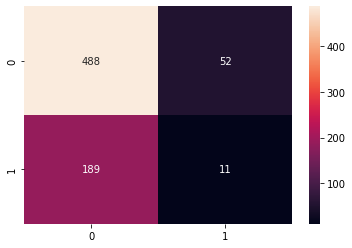

In [43]:
# plot confusion matrix using seaborn library
from sklearn.metrics import confusion_matrix
import seaborn as sns


sns.heatmap(confusion_matrix(actual_labels, predicted_labels), annot=True, fmt="d")

In [45]:
# # import plot_confusion_matrix from sklearn.metrics
# from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(actual_labels, predicted_labels, classes=["decreasing_affinity", "increasing_affinity"])

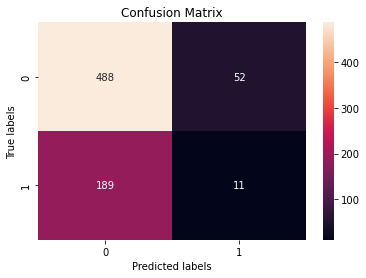

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()

cm = confusion_matrix(actual_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['business', 'health']); 
# ax.yaxis.set_ticklabels(['health', 'business']);

In [32]:
(488 + 11) / (740)

0.6743243243243243

In [47]:
# assess the performance of the model using predicted_labels and actual_labels
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

# print all metrics using predicted_labels and actual_labels
print(classification_report(actual_labels, predicted_labels))
print("Accuracy:", accuracy_score(actual_labels, predicted_labels))
print("Balanced Accuracy:", balanced_accuracy_score(actual_labels, predicted_labels))
print("F1 Score:", f1_score(actual_labels, predicted_labels))
print("Precision Score:", precision_score(actual_labels, predicted_labels, pos_label=0))
print("Recall Score:", recall_score(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       540
           1       0.17      0.06      0.08       200

   micro avg       0.67      0.67      0.67       740
   macro avg       0.45      0.48      0.44       740
weighted avg       0.57      0.67      0.61       740

Accuracy: 0.6743243243243243
Balanced Accuracy: 0.47935185185185186
F1 Score: 0.08365019011406845
Precision Score: 0.1746031746031746
Recall Score: 0.055


In [48]:
print("Precision Score:", precision_score(actual_labels, predicted_labels, pos_label=0))

Precision Score: 0.7208271787296898


In [49]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(actual_labels, predicted_labels)

-0.06571407088565617

In [51]:
# from sklearn.metrics import roc_auc_score


# roc_auc_score()

In [29]:
# assess the performance of the model using predicted_labels and actual_labels
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

# print all metrics using predicted_labels and actual_labels
print(classification_report(actual_labels, predicted_labels))
print("Accuracy:", accuracy_score(actual_labels, predicted_labels))
print("Balanced Accuracy:", balanced_accuracy_score(actual_labels, predicted_labels))
print("F1 Score:", f1_score(actual_labels, predicted_labels))
print("Precision Score:", precision_score(actual_labels, predicted_labels))
print("Recall Score:", recall_score(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       540
           1       0.17      0.06      0.08       200

   micro avg       0.67      0.67      0.67       740
   macro avg       0.45      0.48      0.44       740
weighted avg       0.57      0.67      0.61       740

Accuracy: 0.6743243243243243
Balanced Accuracy: 0.47935185185185186
F1 Score: 0.08365019011406845
Precision Score: 0.1746031746031746
Recall Score: 0.055


In [10]:
train_data

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID
0,0,Q9BPZ3,F118A,P11940
1,0,P01116,Y40C,P50749
2,0,Q96QK1,F534D,Q9UBQ0
3,0,Q96QK1,F534D,Q9UBQ0-2
4,0,O43521-3,G66A,Q07812
...,...,...,...,...
735,0,P84243,Q94A,Q9UER7-3
736,0,Q96QK1,L589D,Q9UBQ0
737,0,Q96QK1,L589D,Q9UBQ0-2
738,0,P23297,F72L,P25815


In [ ]:
# original code.
ligand_WT='YADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFATRYAKKFGVDKAKMMDRLWGDSFFNPKTKKWTNKDTDAEGKPLERAFNMFILDPIFRLFTAIMNFKKDEIPVLLEKLEIVLKGDEKDLEGKALLKVVMRKFLPAADALLEMIVLHLPSPVTAQAYRAEQLYEGPADDANCIAIKNCDPKADLMLYVSKMVPTSDKGRFYAFGRVFAGTVKSGQKVRIQGPNYVPGKKDDLFIKAIQRVVLMMGRFVEPIDDCPAGNIIGLVGIDQFLLKTGTLTTSETAHNMKVMKFSVSPVVQVAVEVKNANDLPKLVEGLKRLSKSDPCVLTYMSESGEHIVAGTGELHLEICLQDLEHDHAGVPLKISPPVVAYRETVESESSQTALSKSPNKHNRIYLKAEPIDEEVSLAIENGIINPRDDFKARARIMADDYGWDVTDARKIWCFGPDGNGPNLVIDQTKAVQYLHEIKDSVVAAFQWATKEGPIFGEEMRSVRVNILDVTLHADAIRGGGQIIPTMRRATYAGFLLADPKIQEPVFLVEIQCPEQAVGGIYSVLNKKRGQVVSEEQRPGTPLFTVKAYLPVNESFGFTGELRQATGGQAFPQMVFDHWSTLGSDPLDPTSKAGEIVLAARKRHGMKEEVPGWQEYYDKL'
Receptor_WT='DEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFATRYAKKFGVDKAKMMDR'
ligand_M='YRRRVLGDVQVYPARGTVAFGSGLHGWAFTVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFATRYAKKFGVDKKWTNKDTDAEGKPLERAFNMFILDPIFRLFTAIMNFKKDEIPVLLEKLEIVLKGDEKDLEGKALLKVVMRKFLPAADALLEMIVLHLPSPVTAQAYRAEQLYEGPADDANCIAIKNCDPKADLMLYVSKMVPTSDKGRFYAFGRVFAGTVKSGQKVRIQGPNYVPGKKDDLFIKAIQRVVLMMGRFVEPIDDCPAGNIIGLVGIDQFLLKTGTLTTSETAHNMKVMKFSVSPVVQVAVEVKNANDLPKLVEGLKRLSKSDPCVLTYMSESGEHIVAGTGELHLEICLQDLEHDHAGVPLKISPPVVAYRETVESESSQTALSKSPNKHNRIYLKAEPIDEEVSLAIENGIINPRDDFKARARIMADDYGWDVTDARKIWCFGPDGNGPNLVIDQTKAVQYLHEIKDSVVAAFQWATKEGPIFGEEMRSVRVNILDVTLHADAIRGGGQIIPTMRRATYAGFLLADPKIQEPVFLVEIQCPEQAVGGIYSVLNKKRGQVVSEEQRPGTPLFTVKAYLPVNESFGFTGELRQATGGQAFPQMVFDHWSTLGSDPLDPTSKAGEIVLAARKRHGMKEEVPGWQEYYDKL'
Receptor_M='DEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFAYADEVLGDVQVYPARGTVAFGSGLHGWAFTIRQFATRYAKKFGVDKAKMMDR'

affinity_change = predict_affinity(ligand_WT,Receptor_WT,ligand_M,Receptor_M)

print ("The predicted Change in binding affinity is:"+str(affinity_change[0])+" kcal/mol")

if affinity_change[0]<0:
    print("Decreasing affinity")
elif affinity_change[0]>0:
    print("increasing affinity")
else:
    print("No Change in affinity!")
